<a href="https://colab.research.google.com/github/cianryan09/Portfolio-Optimization-and-Performance/blob/main/Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Install relevant python libraries.
financetoolkit downloads and updates the security prices for the revelant dates
PyPortfolioOpt
"""

!pip install financetoolkit

!pip install PyPortfolioOpt

# !pip install financedatabase

In [ ]:
"""
mounting google drive to save output
"""

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""
import standard python libraries
"""

import pandas as pd
import numpy as np

In [ ]:
"""
function to obtain all tickers in S&P 500 index
"""

def list_spy_holdings() -> pd.DataFrame:
    # Ref: https://stackoverflow.com/a/75845569/
    # Source: https://www.ssga.com/us/en/intermediary/etfs/funds/spdr-sp-500-etf-trust-spy
    # Note: One of the included holdings is CASH_USD.
    url = 'https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx'
    return pd.read_excel(url, engine='openpyxl', index_col='Ticker', skiprows=4).dropna()

SPY_df = list_spy_holdings()

ticker_list = SPY_df.index.tolist()

ticker_list.remove('-')

index_brb, index_bf = ticker_list.index('BRK.B'), ticker_list.index('BF.B')

ticker_list[index_brb], ticker_list[index_bf] = 'BRK-B', 'BF-B'

print(ticker_list)


['MSFT', 'AAPL', 'NVDA', 'AMZN', 'META', 'GOOGL', 'GOOG', 'BRK-B', 'AVGO', 'LLY', 'JPM', 'XOM', 'TSLA', 'UNH', 'V', 'PG', 'MA', 'JNJ', 'COST', 'HD', 'MRK', 'ABBV', 'CVX', 'CRM', 'WMT', 'BAC', 'NFLX', 'AMD', 'PEP', 'KO', 'TMO', 'WFC', 'ADBE', 'QCOM', 'LIN', 'MCD', 'CSCO', 'ORCL', 'ACN', 'DIS', 'INTU', 'ABT', 'CAT', 'AMAT', 'TXN', 'GE', 'DHR', 'VZ', 'AMGN', 'PFE', 'NEE', 'PM', 'CMCSA', 'NOW', 'IBM', 'GS', 'UNP', 'MU', 'COP', 'SPGI', 'ISRG', 'RTX', 'AXP', 'HON', 'UBER', 'INTC', 'LOW', 'ETN', 'BKNG', 'ELV', 'MS', 'LRCX', 'T', 'C', 'PGR', 'SCHW', 'MDT', 'VRTX', 'BLK', 'SYK', 'TJX', 'NKE', 'BSX', 'UPS', 'CB', 'ADI', 'BA', 'MMC', 'ADP', 'DE', 'PLD', 'REGN', 'KLAC', 'LMT', 'PANW', 'CI', 'MDLZ', 'BX', 'FI', 'AMT', 'BMY', 'SNPS', 'CMG', 'SO', 'TMUS', 'SBUX', 'GILD', 'MO', 'ANET', 'ZTS', 'DUK', 'APH', 'CDNS', 'ICE', 'CL', 'WM', 'CME', 'EQIX', 'FCX', 'EOG', 'TT', 'TGT', 'SHW', 'MCK', 'CVS', 'TDG', 'NXPI', 'PH', 'CEG', 'SLB', 'PYPL', 'BDX', 'ITW', 'CSX', 'GD', 'NOC', 'USB', 'MCO', 'MPC', 'EMR', 'PN

In [ ]:
"""
get start dates for different time periods and the end date to measure performance.
"""


from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

this_first = date.today().replace(day=1)
# end_date = this_first - timedelta(days=1)
# end_date = date(2023,11,30)
end_date = date(2023,12,29)

def get_start_date(from_date = date.today(), years=0, months=0, days=1):

  if years==0:
    start_date = from_date.replace(month=1, day=1)
  else:
    start_date = from_date - relativedelta(years=years) + timedelta(days)

  w = start_date.isoweekday()

  if w == 6:
    start_date += timedelta(2)
    return start_date
  elif w == 7:
    start_date += timedelta(1)
    return start_date
  else:
    return start_date

periods = ['5yr', '3yr', '1yr', 'YTD']
periods_num = [5,3,1,0]

start_dates = [get_start_date(end_date, n) for n in periods_num]
start_dates[-1] = date(2023,1,5)

start_dates_dict = {x:y for (x,y) in list(zip(periods, start_dates))}

print(end_date)
print(start_dates)

2023-12-29
[datetime.date(2018, 12, 31), datetime.date(2020, 12, 30), datetime.date(2022, 12, 30), datetime.date(2023, 1, 5)]


In [ ]:
"""
read file of 5-year security price history.
"""

df = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/Investment_{end_date.strftime('%Y%m%d')}/S&P500_Price_Data_{end_date.strftime('%Y%m%d')}.csv", index_col='date')

# print(df)

df_BM = df[['Benchmark']]
# print(df_BM)

In [ ]:
"""
import relevant modules from the packages. Expected returns are calculated using the CAPM model.
risk_models calulates the covariance matrix.
efficient frontier produces the efficient frontier for all combinations of stocks in the portfolio.
plotting produces a graphical representation of the efficient frontier.
"""

from pypfopt.expected_returns import mean_historical_return, capm_return
from pypfopt.risk_models import CovarianceShrinkage, sample_cov
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting
import matplotlib.pyplot as plt
from financetoolkit import Toolkit

In [ ]:
"""
This calls the security price data for all tickers in the portfolio from the relevant API.
"""

companies = Toolkit(

    # tickers=['GOOGL', 'MSFT', 'AMZN', 'META', 'NVDA', 'AAPL', 'TSLA', 'GOOG', 'SPY'],
    tickers= ['TSLA', 'V', 'NVO', 'ASML', 'AAPL', 'MA', 'DKNG', 'LIN', 'ZTS'],
    # tickers = ['AAPL'],
    start_date = f"{start_dates[0]}",
    end_date = f"{start_dates[-1]}",
    risk_free_rate = "5y",
    benchmark_ticker = "SPY",
    api_key="d8cbca992455c7db128f6d466565b642",
)

In [ ]:
c = companies.get_historical_data()

df = pd.DataFrame(c)['Adj Close']
print(df)

df_BM = df[['Benchmark']]

Obtaining historical data: 100%|██████████| 10/10 [00:01<00:00,  9.39it/s]


             TSLA      V   NVO   ASML   AAPL     MA  DKNG    LIN    ZTS  \
date                                                                      
2018-12-31  22.19 127.04 21.46 148.37  37.75 182.95   NaN 143.71  82.26   
2019-01-02  20.67 127.99  21.8 149.02  37.79  184.0   NaN 144.78  81.24   
2019-01-03  20.02 123.38 21.97  140.8  34.03  175.7   NaN 140.26  78.44   
2019-01-04  21.18 128.69 22.05 146.89  35.48 184.02   NaN 144.26  81.51   
2019-01-07  22.33 131.01 22.19 150.25   35.4 185.44   NaN 144.13   82.0   
...           ...    ...   ...    ...    ...    ...   ...    ...    ...   
2022-12-29 121.82 205.66 66.65 545.07 128.55 345.08 11.27 324.29 146.06   
2022-12-30 123.18 205.36 66.72 540.06 128.87  344.6 11.39 320.78 144.48   
2023-01-03  108.1 204.99 67.52  543.2 124.05 343.68 11.05 313.08 144.78   
2023-01-04 113.64 210.15 67.42 564.21 125.33 351.95 11.71 311.53 146.86   
2023-01-05 110.34 208.67 67.17 558.76  124.0  348.6 11.48 300.43  143.4   

            Benchmark  


In [ ]:
"""
calculates the expected returns using the CAPM model. The parameters are 5-year market returns (S&P index) and 5-year US Treasury rate
"""

# Fine Tuned

# 5y US Treasuries - 01/05/2024
rf = 0.04567

mu = capm_return(df, df_BM, risk_free_rate=rf)
S = CovarianceShrinkage(df).ledoit_wolf()

print(mu)
print(S)

TSLA        0.16775574689176656
V            0.1356040442745489
NVO         0.09165745435891412
ASML        0.16115505031480773
AAPL        0.14852795525418305
MA           0.1471319411233066
DKNG         0.1726230632007832
LIN         0.12566253717374576
ZTS          0.1236599608338992
Benchmark   0.12822136888047253
Name: mkt, dtype: float64
                         TSLA                    V                  NVO  \
TSLA       0.4497081937323608   0.0749013234360625  0.03407202976466675   
V          0.0749013234360625    0.093133125078957 0.030268123789539744   
NVO       0.03407202976466675 0.030268123789539744  0.07736904738997642   
ASML      0.13298188122705873  0.07423264122591468  0.04314123434234253   
AAPL      0.11351067923689752  0.06450470366172967  0.03256400258415697   
MA         0.0843222181757439  0.09399202571300744  0.03089180915583535   
DKNG      0.15166435550317145  0.06869605753933894 0.037194399964943455   
LIN       0.06019346264276683  0.05529623783324604 0.0

In [ ]:
"""
Calculates efficient frontier. Also calculates the weights that maximise the sharpe ratio of the portfolio.
"""

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
# ef.save_weights_to_file("weights.txt")  # saves to file

cleaned_weights_reduced = {x:y for x,y in cleaned_weights.items() if y!=0}
print(cleaned_weights_reduced)

ef_pp = ef.portfolio_performance(verbose=True)

{'V': 0.02645, 'NVO': 0.09292, 'AAPL': 0.00652, 'DKNG': 0.0215, 'LIN': 0.06265, 'ZTS': 0.04122, 'Benchmark': 0.74874}
Expected annual return: 12.6%
Annual volatility: 22.1%
Sharpe Ratio: 0.48


In [ ]:
"""
caluclates the weights of the minimum variance portfolio.
"""
# Minimum Variance portfolio

S = CovarianceShrinkage(df).ledoit_wolf()

# You don't have to provide expected returns in this case
ef_mv = EfficientFrontier(None, S, weight_bounds=(0, 1))
ef_mv.min_volatility()
weights = ef_mv.clean_weights()
print(weights)

ef_pp = ef_mv.portfolio_performance(verbose=True)

OrderedDict([('TSLA', 0.0), ('V', 0.0), ('NVO', 0.32327), ('ASML', 0.0), ('AAPL', 0.0), ('MA', 0.0), ('DKNG', 0.0), ('LIN', 0.0431), ('ZTS', 0.02967), ('Benchmark', 0.60396)])
Annual volatility: 21.0%


In [ ]:
ef_pp = ef.portfolio_performance(verbose=True)

Expected annual return: 12.6%
Annual volatility: 22.1%
Sharpe Ratio: 0.48


In [ ]:
"""
creates a sample of 10,000 different portfolios with random weights.
"""

n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

print("Sample portfolio returns:", rets)
print("Sample portfolio volatilities:", stds)

Sample portfolio returns: [0.13883398 0.13128835 0.14233383 ... 0.13360054 0.15554489 0.1484734 ]
Sample portfolio volatilities: 0       0.2800292457849438
1      0.25168991959091913
2       0.3255989665978453
3      0.37196211906121945
4      0.30983121838235106
               ...        
9995    0.2928287602524862
9996   0.28138791352205145
9997   0.24885037924613623
9998   0.38505706783256793
9999   0.33547489453256046
Length: 10000, dtype: float64


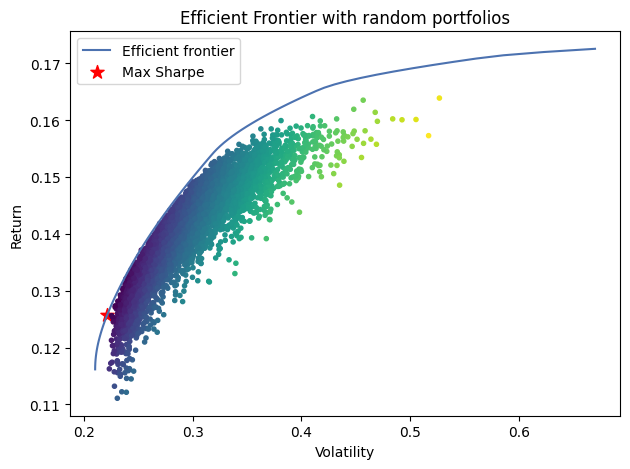

In [ ]:
"""
Plot efficient frontier with Monte Carlo simulation
"""
ef_ = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
"""
gets discrete allocation, i.e. number of shares to but that closest matches
"""

from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

fund_value = 75000

latest_prices = get_latest_prices(df)


da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=fund_value)
allocation, leftover = da.lp_portfolio()
# allocation['USD'] = round(leftover, 2)
print(allocation)
print(str('Cash:'), np.round(leftover,2))



{'NVO': 361, 'DKNG': 4, 'LIN': 11, 'ZTS': 16, 'Benchmark': 121}
Cash: 29.24


In [ ]:
"""
Calculcates Benchmark expected return and covariance matrix

"""

mu_bm = capm_return(df_BM, df_BM, risk_free_rate=rf)
S_bm = CovarianceShrinkage(df_BM).ledoit_wolf()

In [ ]:
"""
calculates volatility of the benchmark. Weight defaults to 1.

"""

ef_bm = EfficientFrontier(mu_bm, S_bm)
weights_bm = ef_bm.max_sharpe()

cleaned_weights_bm = ef_bm.clean_weights()
# ef.save_weights_to_file("weights.txt")  # saves to file

cleaned_weights_bm_reduced = {x:y for x,y in cleaned_weights_bm.items() if y!=0}
print(cleaned_weights_bm_reduced)

ef_bm_pp = ef_bm.portfolio_performance(verbose=True)

{'Benchmark': 1.0}
Expected annual return: 15.6%
Annual volatility: 21.0%
Sharpe Ratio: 0.65


In [ ]:
spare_cash = 1 - sum(list(cleaned_weights_reduced.values()))

residual = max(0, spare_cash)
print(residual)

# cleaned_weights_reduced['USD'] = round(residual, 5)

# print(cleaned_weights_reduced['USD'])

0


In [ ]:
# ef.save_weights_to_file("weights.txt")  # saves to file

In [ ]:
no_of_stocks = list(allocation.keys())
print(len(no_of_stocks))

stocks = len(list(cleaned_weights_reduced.keys()))
print(stocks)

35
47


In [ ]:
def calc_returns(df, tickers, weights, start, end, rebal=None, inc=1):

  df_new = df[tickers].loc[str(start):, ]

  df_new = df_new.bfill()

  num = np.array(df_new.to_numpy().transpose())

  weights = np.array([weights])

  # print(weights)

  sum_wgts = sum(weights[0])

  if rebal is None:

    z = df_new[tickers].loc[str(start)].to_numpy()
    a = df_new[tickers].loc[str(end_date)].to_numpy()

    div = np.divide(a, z)

    matrix = weights @ div

    result = np.round( (matrix[0] - sum_wgts ) * 100, 3)
    return result

  else:

    if num.shape[1] < rebal:
      rebal = num.shape[1] - 1

    if rebal > 1:
      inc = rebal + 1

    m = np.array([num[n][rebal::inc] for n in range(len(num))])
    o = np.array([num[n][:-rebal:inc] for n in range(len(num))])

    div = np.array([(np.divide(m[i], o[i])) for i in range(len(num))])
    div[np.isnan(div)] = 1.0

    r_prod = weights @ div

    result = np.round((np.product(r_prod) - sum_wgts) * 100, 3)

    return result


In [ ]:
weights = tuple(cleaned_weights_reduced.values())[:]
tickers = list(cleaned_weights_reduced.keys())[:]
print(len(tickers))

47


In [ ]:
freq = 5

S_test = CovarianceShrinkage(df, frequency=252/freq).ledoit_wolf()
# print(S_test)

a = np.array([tuple(cleaned_weights.values())])

p_var = a @ S_test.to_numpy() @ a.T

std_dev = np.sqrt(p_var)

std_dev_ann = np.sqrt(p_var) * ((252/freq) ** (.5))
print(p_var)
print(std_dev)
print(std_dev_ann)

[[9.7216701e-05]]
[[0.00985985]]
[[0.06999801]]


In [ ]:
def real_vol(df, start, weights, rebal = 1):

  if rebal is None:
    rebal = 1

  freq = 252/rebal

  df_new = df.loc[str(start):, ]
  S_cov_shrink = CovarianceShrinkage(df_new, frequency=freq).ledoit_wolf().to_numpy()
  # print(S_cov_shrink.shape)
  weights_array = np.array([weights])
  p_var = weights_array @ S_cov_shrink @ weights_array.T
  std_dev = np.sqrt(p_var)
  std_dev_ann = std_dev * ((252/freq) ** .5)
  try:
    return std_dev_ann[0][0]
  except:
    return  std_dev_ann
  # return std_dev[0][0]

wgts = tuple(cleaned_weights.values())

vols = np.array([real_vol(df, start, wgts, 1) for start in start_dates])
vol_array = np.tile(vols, (6,1))
vol_array_T = vol_array.T * 100
print(vol_array_T)

[[ 6.99980123  6.99980123  6.99980123  6.99980123  6.99980123  6.99980123]
 [ 7.97585939  7.97585939  7.97585939  7.97585939  7.97585939  7.97585939]
 [12.12867948 12.12867948 12.12867948 12.12867948 12.12867948 12.12867948]
 [12.1237494  12.1237494  12.1237494  12.1237494  12.1237494  12.1237494 ]]


In [ ]:
#bm vol

vols_bm = np.array([real_vol(df_BM, start, 1, 1) for start in start_dates])
vol_bm_array = np.tile(vols_bm, (6,1))
vol_bm_array_T = vol_bm_array.T * 100

In [ ]:
# calculate returns

weights = tuple(cleaned_weights_reduced.values())[:]
tickers = list(cleaned_weights_reduced.keys())[:]
rebal_freq = {'No Rebalancing (%)': None, 'Daily (%)': 1, 'Weekly (%)': 5, 'Monthly (%)': 20, 'Quarterly': 60, 'Yearly (%)': 252}

returns = np.array([[calc_returns(df, tickers, weights, s, end_date, rebal=r ) for s in start_dates] for r in list(rebal_freq.values())])

# returns = np.array(calc_returns(df, tickers, weights, start_dates[-1], end_date, rebal=None ))

bm_returns = np.array([[calc_returns(df, ['Benchmark'], [1], s, end_date, rebal=r ) for s in start_dates] for r in list(rebal_freq.values())])

print(returns)
print(bm_returns)

[[36.872 22.22   7.472  8.629]
 [32.545 20.486  7.886  8.759]
 [17.895  9.535  1.803  8.198]
 [26.177 14.772  4.806  1.44 ]
 [16.588 11.251  6.651  6.41 ]
 [22.839 11.327  7.472  8.629]]
[[106.369  33.578  26.177  26.709]
 [106.369  33.578  26.177  26.709]
 [ 74.829  21.768  20.707  22.57 ]
 [110.062  22.788  16.814  20.675]
 [101.507  25.123  24.733  24.436]
 [ 63.023   5.687  26.177  26.709]]


In [ ]:
# performance - annualised

def annualised_returns(df, start, end, ret, rebal, inc=252):

  if rebal == 0:

    index_vals = df.index.values.tolist()

    end = index_vals.index(str(end))

    start = index_vals.index(str(start))

    rebal = ( end - start ) / inc

  ann = np.round(((( 1 + ret / 100) ** (1/rebal)) - 1 ) * 100, 3)

  return ann

returns_T = returns.T
bm_returns_T = bm_returns.T

portfolio_annualised_returns = np.array([[annualised_returns(df, start, end_date, rets, rebal) for rets in returns_T[n]] for start, n, rebal in zip(start_dates, range(len(returns_T)), periods_num)])
bm_returns_ann = np.array([annualised_returns(df, start, end_date, bm, rebal) for start, bm, rebal in zip(start_dates, bm_returns_T, periods_num)])

print(portfolio_annualised_returns)
print(bm_returns_ann)

[[6.479 5.797 3.347 4.76  3.117 4.2  ]
 [6.917 6.409 3.082 4.7   3.618 3.641]
 [7.472 7.886 1.803 4.806 6.651 7.472]
 [8.737 8.869 8.301 1.457 6.49  8.737]]
[[15.592 15.592 11.821 16.003 15.042 10.268]
 [10.132 10.132  6.785  7.083  7.757  1.861]
 [26.177 26.177 20.707 16.814 24.733 26.177]
 [27.071 27.071 22.871 20.949 24.764 27.071]]


In [ ]:
# sharpes

sharpe = np.round(np.divide(portfolio_annualised_returns, vol_array_T), 3)
print(sharpe)

sharpe_bm = np.round(np.divide(bm_returns_ann, vol_bm_array_T), 3)
print(sharpe_bm)

sharpe_differential = sharpe - sharpe_bm
print(sharpe_differential)

[[0.926 0.828 0.478 0.68  0.445 0.6  ]
 [0.867 0.804 0.386 0.589 0.454 0.457]
 [0.616 0.65  0.149 0.396 0.548 0.616]
 [0.721 0.732 0.685 0.12  0.535 0.721]]
[[0.743 0.743 0.563 0.763 0.717 0.489]
 [0.576 0.576 0.386 0.403 0.441 0.106]
 [2.006 2.006 1.587 1.289 1.896 2.006]
 [2.072 2.072 1.751 1.604 1.896 2.072]]
[[ 0.183  0.085 -0.085 -0.083 -0.272  0.111]
 [ 0.291  0.228  0.     0.186  0.013  0.351]
 [-1.39  -1.356 -1.438 -0.893 -1.348 -1.39 ]
 [-1.351 -1.34  -1.066 -1.484 -1.361 -1.351]]


In [ ]:
# standard deviations
w = np.array([list(cleaned_weights.values())])

stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
# print(stds[0])
std_bm = np.sqrt(ef_bm.cov_matrix)[0][0]

sharpes = np.round(np.divide(portfolio_annualised_returns, stds*100), 3)
sharpes_bm = np.round(np.divide(bm_returns_ann, std_bm*100), 3)

print(sharpes)
print(sharpes_bm)

[[0.926 0.828 0.478 0.68  0.445 0.6  ]
 [0.988 0.916 0.44  0.671 0.517 0.52 ]
 [1.067 1.127 0.258 0.687 0.95  1.067]
 [1.248 1.267 1.186 0.208 0.927 1.248]]
[[0.743 0.743 0.563 0.763 0.717 0.489]
 [0.483 0.483 0.323 0.338 0.37  0.089]
 [1.248 1.248 0.987 0.801 1.179 1.248]
 [1.29  1.29  1.09  0.999 1.18  1.29 ]]


In [ ]:
# generate data frames for reports

df_returns = pd.DataFrame(returns_T, columns=list(rebal_freq.keys()), index=periods)
df_bm_returns = pd.DataFrame(bm_returns_T, columns=list(rebal_freq.keys()), index=periods)

print(df_returns)
print(df_bm_returns)

     No Rebalancing (%)  Daily (%)  Weekly (%)  Monthly (%)  Quarterly  \
5yr              36.872     32.545      17.895       26.177     16.588   
3yr              22.220     20.486       9.535       14.772     11.251   
1yr               7.472      7.886       1.803        4.806      6.651   
YTD               8.629      8.759       8.198        1.440      6.410   

     Yearly (%)  
5yr      22.839  
3yr      11.327  
1yr       7.472  
YTD       8.629  
     No Rebalancing (%)  Daily (%)  Weekly (%)  Monthly (%)  Quarterly  \
5yr             106.369    106.369      74.829      110.062    101.507   
3yr              33.578     33.578      21.768       22.788     25.123   
1yr              26.177     26.177      20.707       16.814     24.733   
YTD              26.709     26.709      22.570       20.675     24.436   

     Yearly (%)  
5yr      63.023  
3yr       5.687  
1yr      26.177  
YTD      26.709  


In [ ]:
df_returns_ann = pd.DataFrame(portfolio_annualised_returns, columns=list(rebal_freq.keys()), index=periods)
df_bm_returns_ann = pd.DataFrame(bm_returns_ann, columns=list(rebal_freq.keys()), index=periods)

print(df_returns_ann)
print(df_bm_returns_ann)

     No Rebalancing (%)  Daily (%)  Weekly (%)  Monthly (%)  Quarterly  \
5yr               6.479      5.797       3.347        4.760      3.117   
3yr               6.917      6.409       3.082        4.700      3.618   
1yr               7.472      7.886       1.803        4.806      6.651   
YTD               8.737      8.869       8.301        1.457      6.490   

     Yearly (%)  
5yr       4.200  
3yr       3.641  
1yr       7.472  
YTD       8.737  
     No Rebalancing (%)  Daily (%)  Weekly (%)  Monthly (%)  Quarterly  \
5yr              15.592     15.592      11.821       16.003     15.042   
3yr              10.132     10.132       6.785        7.083      7.757   
1yr              26.177     26.177      20.707       16.814     24.733   
YTD              27.071     27.071      22.871       20.949     24.764   

     Yearly (%)  
5yr      10.268  
3yr       1.861  
1yr      26.177  
YTD      27.071  


In [ ]:
#vols

vol_df = pd.DataFrame(vol_array_T, columns=list(rebal_freq.keys()), index=periods).iloc[:, :1]
vol_bm_df = pd.DataFrame(vol_bm_array_T, columns=list(rebal_freq.keys()), index=periods).iloc[:, :1]

print(vol_df)

# sharpes

sharpe_df = pd.DataFrame(sharpe, columns=list(rebal_freq.keys()), index=periods)
sharpe_bm_df = pd.DataFrame(sharpe_bm, columns=list(rebal_freq.keys()), index=periods)
sharpe_diff_df = pd.DataFrame(sharpe_differential, columns=list(rebal_freq.keys()), index=periods)

print(sharpe_df)

     No Rebalancing (%)
5yr            6.999801
3yr            7.975859
1yr           12.128679
YTD           12.123749
     No Rebalancing (%)  Daily (%)  Weekly (%)  Monthly (%)  Quarterly  \
5yr               0.926      0.828       0.478        0.680      0.445   
3yr               0.867      0.804       0.386        0.589      0.454   
1yr               0.616      0.650       0.149        0.396      0.548   
YTD               0.721      0.732       0.685        0.120      0.535   

     Yearly (%)  
5yr       0.600  
3yr       0.457  
1yr       0.616  
YTD       0.721  


In [ ]:
# # generate reports csv

# weights

weights_df = pd.Series(cleaned_weights_reduced).to_frame().reset_index()
weights_df.columns = ['Ticker', 'Weight']
weights_df.to_csv(f"/content/drive/MyDrive/Colab Notebooks/Investment_{end_date.strftime('%Y%m%d')}/Weights_{end_date.strftime('%Y%m%d')}.csv", index=False)


# # allocations

allocation_df = pd.DataFrame({'symbol': allocation.keys(), 'number': allocation.values()})
allocation_df.to_csv(f"/content/drive/MyDrive/Colab Notebooks/Investment_{end_date.strftime('%Y%m%d')}/Allocation_{end_date.strftime('%Y%m%d')}.csv", index=False)

# # results

ef_df = pd.DataFrame({'Measure': ['Expected annual return', 'Annual volatility', 'Sharpe Ratio'], 'Result': ef_pp})
ef_df.to_csv(f"/content/drive/MyDrive/Colab Notebooks/Investment_{end_date.strftime('%Y%m%d')}/Results_{end_date.strftime('%Y%m%d')}.csv", index=False)

ef_bm_df = pd.DataFrame({'Measure': ['Expected annual return', 'Annual volatility', 'Sharpe Ratio'], 'Result': ef_bm_pp})
ef_bm_df.to_csv(f"/content/drive/MyDrive/Colab Notebooks/Investment_{end_date.strftime('%Y%m%d')}/Benchmark_Results_{end_date.strftime('%Y%m%d')}.csv", index=False)

# performance

df_returns.to_csv(f"/content/drive/MyDrive/Colab Notebooks/Investment_{end_date.strftime('%Y%m%d')}/Performance_{end_date.strftime('%Y%m%d')}.csv")
df_bm_returns.to_csv(f"/content/drive/MyDrive/Colab Notebooks/Investment_{end_date.strftime('%Y%m%d')}/SPY_Performance_{end_date.strftime('%Y%m%d')}.csv")

# performance - annualised

df_returns_ann.to_csv(f"/content/drive/MyDrive/Colab Notebooks/Investment_{end_date.strftime('%Y%m%d')}/Performance_Annualised_{end_date.strftime('%Y%m%d')}.csv")
df_bm_returns_ann.to_csv(f"/content/drive/MyDrive/Colab Notebooks/Investment_{end_date.strftime('%Y%m%d')}/SPY_Performance_Annusalised_{end_date.strftime('%Y%m%d')}.csv")

#realised vol

vol_df.to_csv(f"/content/drive/MyDrive/Colab Notebooks/Investment_{end_date.strftime('%Y%m%d')}/Realized_Volatility_{end_date.strftime('%Y%m%d')}.csv")
vol_bm_df.to_csv(f"/content/drive/MyDrive/Colab Notebooks/Investment_{end_date.strftime('%Y%m%d')}/Realized_Volatility_BM_{end_date.strftime('%Y%m%d')}.csv")

# sharpes

sharpe_df.to_csv(f"/content/drive/MyDrive/Colab Notebooks/Investment_{end_date.strftime('%Y%m%d')}/Sharpe_Ratio_{end_date.strftime('%Y%m%d')}.csv")
sharpe_bm_df.to_csv(f"/content/drive/MyDrive/Colab Notebooks/Investment_{end_date.strftime('%Y%m%d')}/Sharpe_Ratio_BM_{end_date.strftime('%Y%m%d')}.csv")
sharpe_diff_df.to_csv(f"/content/drive/MyDrive/Colab Notebooks/Investment_{end_date.strftime('%Y%m%d')}/Sharpe_Ratio_Differential_{end_date.strftime('%Y%m%d')}.csv")

In [ ]:
#!/usr/bin/env python

try:
    # For Python 3.0 and later
    from urllib.request import urlopen
except ImportError:
    # Fall back to Python 2's urllib2
    from urllib2 import urlopen

import certifi
import json

def get_jsonparsed_data(url):
    """
    Receive the content of ``url``, parse it as JSON and return the object.

    Parameters
    ----------
    url : str

    Returns
    -------
    dict
    """
    response = urlopen(url, cafile=certifi.where())
    data = response.read().decode("utf-8")
    return json.loads(data)

url = ("https://financialmodelingprep.com/api/v3/quotes/index?apikey=d8cbca992455c7db128f6d466565b642")
# print(get_jsonparsed_data(url))

indices = get_jsonparsed_data(url)

import pandas as pd

df_indices = pd.DataFrame(indices)
print(df_indices)

df_indices.to_csv("Indices.csv", index=False)

<ipython-input-67-0042ed80735c>:25: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


       symbol                              name      price  changesPercentage  \
0      ^W2DOW    Dow Jones Global ex-U.S. Index    271.560            -1.2545   
1    XMADN.IS                   BIST MADENCILIK   5766.490            -0.1759   
2      ^W5000  Wilshire 5000 Total Market Index  42053.200             0.0000   
3      ^RUITR         Russell 1000 Total Return  16177.121            -0.4019   
4     ^SET.BK                         SET Index   1401.720            -0.3767   
..        ...                               ...        ...                ...   
167    ^VIX1D       Cboe 1-Day Volatility Index      9.940           -14.8243   
168      ^DJX   1/100 DOW JONES INDUSTRIAL AVER    377.640             0.1406   
169      ^OEX                     S&P 100 INDEX   2247.340            -0.3127   
170     ^AXTJ         S&P/ASX 200 Communication   1575.600            -0.5303   
171  IDX30.JK                             IDX30    502.801           -50.0173   

       change     dayLow   